In [1]:
import json
import uuid
import pandas as pd

import getpass
import os

In [2]:

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("ANTHROPIC_API_KEY")

In [227]:

data = pd.read_excel("reddit-comments-eval.xlsx")
print(f"Number of rows: {data.shape[0]}")

error_columns = ['keywords-node', 'tool-node', 'tone-summary-node', 'reply-node']

Number of rows: 39


In [230]:
data = data[~data['keywords-node'].isna()]
data.shape
# data[error_columns] = data[error_columns].astype(int).astype(bool)

# data[error_columns].head()

# data['no_errors'] = data[error_columns].all(axis=1)

(35, 17)

In [149]:
import logging
import operator
from typing import Annotated, List, Optional, TypedDict, Sequence
from langchain_core.messages import BaseMessage

logging.basicConfig(level=logging.WARNING)
logger = logging.getLogger("reddit-comments")

class State(TypedDict):
    batch_id: str
    input: Annotated[Sequence[BaseMessage], operator.add]
    output: Annotated[Sequence[BaseMessage], operator.add]
    messages: Annotated[Sequence[BaseMessage], operator.add]


In [150]:
from langchain_anthropic import ChatAnthropic
llm = ChatAnthropic(model='claude-3-5-sonnet-20240620')

In [200]:
def validate_llm_performance(state: State):
    batch_id = state["batch_id"][-1]
    input = state['input'][-1]
    output = state['output'][-1]

    prompt = f"""You are a validator who is diligent and careful. When things are incorrect, you call it out and nothing gets past you.
    Given a input and ouput, your goal is to check if the output followed the directions in the input.

    Special instructions: 
    1. If the input task was to format something as a python list of strings, you can ignore that. 
    2. If the task is to extract two words, and more words have been extracted, ignore that. That output is correct.
    3. If there is a word-limit, you can ignore that as well as long as the output is close to the requested word limit.

    Analyze and output in JSON format with keys: "reason" (the reason why this is correct or incorrect), "check" (1 for correct and 0 for incorrect)
    
    Please, absolutely no preamble in the response, just a json output. You'll be penalized otherwise.

    Input: {input}
    Output: {output}
    

    """
    response = llm.invoke(prompt)
    return {"batch_id": batch_id,"input": [input], "output":[output], "messages": [response.content]}


In [201]:
from langgraph.graph import StateGraph, Graph, START, END

workflow = StateGraph(State)

workflow.add_node("validate_llm_performance", validate_llm_performance)

workflow.add_edge(START, "validate_llm_performance")
workflow.add_edge("validate_llm_performance", END)

graph = workflow.compile()


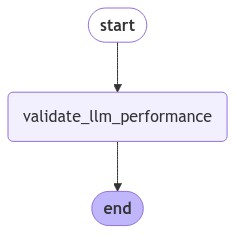

In [202]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(e)
    # This requires some extra dependencies and is optional
    pass

In [234]:
start = 31
end = 40

mappings = [
    ('prompt-1', 'output-keywords'),
    ('prompt-2', 'output-article_search'),
    ('prompt-3', 'output-replies'),
    ('prompt-4', 'output-reply')
    ]

llm_evals_of_entire_posts = {}
for index, row in data[start:end].iterrows():
    # Cycle through each post's input and outputs.
    # Each post has 4 prompts and 4 outputs
    json_data = row.to_dict()
    batch_id = json_data['post_id']

    # Cycle through each input/output prompt/response generated by the LLM and evaluate it
    input_output_evaluation = []
    for prompt_key, output_key in mappings:
        prompt_text = json_data.get(prompt_key, None)
        output_text = json_data.get(output_key, None)
        evaluation_response = graph.invoke({"batch_id": [batch_id], "input": [prompt_text], "output": [output_text]})
        input_output_evaluation.append(evaluation_response)

    llm_evals_of_entire_posts[batch_id] = input_output_evaluation


In [235]:
def write_to_file(post_id, post_evaluation):
    previous_responses = pd.read_excel("llm-evals.xlsx", sheet_name="Sheet1")

    checks = {f"check-{idx+1}": json.loads(r['messages'][0])['check'] for idx, r in enumerate(post_evaluation)}
    reasons = {f"reason-{idx+1}": json.loads(r['messages'][0])['reason'] for idx, r in enumerate(post_evaluation)}
    inputs = {f"input-{idx+1}": r["input"][0] for idx, r in enumerate(post_evaluation)}
    outputs = {f"output-{idx+1}": r["output"][0] for idx, r in enumerate(post_evaluation)}

    checks_pd = pd.DataFrame([{**inputs, **outputs, **checks, **reasons}])  
    checks_pd['batch_id'] = post_id 

    updated_responses = pd.concat([previous_responses, checks_pd])
    updated_responses.to_excel("llm-evals.xlsx", sheet_name="Sheet1", index=False)

In [236]:
for post_id, post_evaluation in llm_evals_of_entire_posts.items():
    try:
        write_to_file(post_id, post_evaluation)
    except Exception as e:
        print(post_id, e)


# Analysis

In [268]:
data_llm_outputs = pd.read_excel("llm-evals.xlsx")
data_llm_outputs.rename(columns={
    "check-1": "keywords-node",
    "check-2": "tool-node",
    "check-3": "tone-summary-node",
    "check-4": "reply-node"
}, inplace=True)

In [269]:
class Node:
    def __init__(self, name):
        self.name = name
        self.parents = []

    def add_parent(self, parent):
        self.parents.append(parent)
    
def create_graph():
    nodes = {
        "keywords-node": Node("keywords-node"),
        "tool-node": Node("tool-node"),
        "tone-summary-node": Node("tone-summary-node"),
        "reply-node": Node("reply-node")
    }

    nodes['reply-node'].add_parent(nodes['tone-summary-node'])
    nodes['tone-summary-node'].add_parent(nodes['tool-node'])
    nodes['tool-node'].add_parent(nodes['keywords-node'])

    return nodes

In [270]:
analysis_graph = create_graph()
analysis_graph

{'keywords-node': <__main__.Node at 0x16cd5d970>,
 'tool-node': <__main__.Node at 0x16cd5da30>,
 'tone-summary-node': <__main__.Node at 0x16cd5dd90>,
 'reply-node': <__main__.Node at 0x16cd5d310>}

In [271]:
# Rewritten code

from typing import Dict, List, Tuple

def calculate_probabilities(node: str, data: pd.DataFrame, dependencies: List[Node]) -> Tuple[float, Dict[str, float]]:
    """Calculate failure probabilities for the node and its upstream dependencies."""
    node_fails = data[node] == False
    p_node_fails = node_fails.mean()
    
    # Calculate independent failure probability
    if not dependencies:
        p_independent_fail = p_node_fails
    else:
        deps_pass = data[[dep.name for dep in dependencies]].all(axis=1)
        p_independent_fail = (node_fails & deps_pass).sum() / deps_pass.sum()
    
    # Calculate conditional failure probabilities for dependencies
    p_node_fails_given_dep_fails = {}
    for dep in dependencies:
        dep_fails = data[dep.name] == False

        p_node_fails_given_dep_fails[dep.name] = (node_fails & dep_fails).sum() / dep_fails.sum() if dep_fails.sum() != 0 else 0

        
    return p_node_fails, p_independent_fail, p_node_fails_given_dep_fails

def find_root_cause(node: str, data: pd.DataFrame, graph: Dict[str, Node]) -> Tuple[List[str], float, Dict[str, float]]:
    """Recursively find the root cause of failures, tracing from downstream to upstream."""
    dependencies = graph[node].parents  # These are upstream nodes

    p_node_fails, p_independent_fail, p_node_fails_given_dep_fails = calculate_probabilities(node, data, dependencies)
    
    print(f"Analyzing node: {node}")
    print(f"Overall failure probability for this node: {p_node_fails:.4f}")
    print(f"Independent failure probability: {p_independent_fail:.4f}")
    print(f"Node failure because dep fails: {max([v for _, v in p_node_fails_given_dep_fails.items()])}")
    print(f"Conditional failure probabilities given upstream dependency failures:")
    for dep, prob in p_node_fails_given_dep_fails.items():
        print(f"  P({node} fails | {dep} fails): {prob:.4f}")
    print()
    
    # Check if independent failure is more likely than any upstream dependency failure
    if p_independent_fail > max(p_node_fails_given_dep_fails.values(), default=0) :
        return [node], p_independent_fail, p_node_fails_given_dep_fails

    if not dependencies:
        return [node], p_independent_fail, p_node_fails_given_dep_fails

    max_dep = max(p_node_fails_given_dep_fails, key=p_node_fails_given_dep_fails.get)
    upstream_path, upstream_independent_prob, upstream_final_probs = find_root_cause(max_dep, data, graph)
    
    return [node] + upstream_path, upstream_independent_prob, upstream_final_probs

def improve_system(downstream_node: str, data: pd.DataFrame, graph: Dict[str, Node]) -> Tuple[List[str], float, Dict[str, float]]:
    """Entry point for the root cause analysis, starting from the most downstream node."""
    path, independent_prob, final_probs = find_root_cause(downstream_node, data, graph)
    
    print("\nRoot cause analysis complete.")
    print(f"Debug path (from downstream to upstream): {' -> '.join(path)}")
    print(f"Most likely root cause (most upstream issue): {path[-1]}")
    print(f"Independent failure probability of root cause: {independent_prob:.4f}")
    print("Conditional failure probabilities given root cause's dependency failures:")
    for dep, prob in final_probs.items():
        print(f"  P({path[-1]} fails | {dep} fails): {prob:.4f}")
    
    if independent_prob > max(final_probs.values(), default=0):
        print()
        print(f"The most likely cause is an independent failure in node {path[-1]}")
    else:
        most_likely_dep = max(final_probs.values(), default=0)
        print()
        print(f"The most likely cause is a failure in dependency: {most_likely_dep}")
    
    return path, independent_prob, final_probs

print()
print(f"Focus on node: {improve_system('reply-node', data=data_llm_outputs, graph=analysis_graph)}")


Analyzing node: reply-node
Overall failure probability for this node: 0.1290
Independent failure probability: 0.1333
Node failure because dep fails: 0.0
Conditional failure probabilities given upstream dependency failures:
  P(reply-node fails | tone-summary-node fails): 0.0000


Root cause analysis complete.
Debug path (from downstream to upstream): reply-node
Most likely root cause (most upstream issue): reply-node
Independent failure probability of root cause: 0.1333
Conditional failure probabilities given root cause's dependency failures:
  P(reply-node fails | tone-summary-node fails): 0.0000

The most likely cause is an independent failure in node reply-node
Focus on node: (['reply-node'], 0.13333333333333333, {'tone-summary-node': 0.0})
